# Skrinning Stuff

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

currentDir = os.getcwd()
sys.path.append(os.path.join(currentDir, '../code/'))
import geomUtils as geom
import IceSheet

In [2]:
geom.charLength('hex', [2.])

1.7320508075688774

In [3]:
diamsCrystal = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.])  # m
gapMelt = 1.e-4  # m

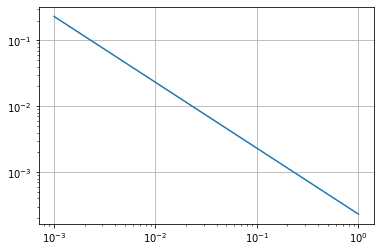

In [4]:
porosities = [(geom.periphery('hex', [x])*gapMelt/2)/(geom.area('hex', [x])) for x in diamsCrystal]
plt.loglog(diamsCrystal, porosities)
plt.grid()

In [5]:
mySheet = IceSheet.IceSheet()

In [6]:
mySheet._ice['rho']

916.8

In [8]:
A, B, b, U = mySheet.setupModel()
A

1.327909014709533e-07
0.02040816326530612
301225.45714285714 1.0
1.0
0.001001001001001001 301225.45714285714
1.2017017017017024
133.9424199039626 33.48560497599065 11.959144634282374


array([[ 3.98998808, -2.4034034 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.2017017 ,  3.4034034 , -1.2017017 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.2017017 ,  3.4034034 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.4034034 ,
        -1.2017017 ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -1.2017017 ,
         3.4034034 , -1.2017017 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -2.4034034 ,  3.4034034 ]])

In [9]:
USoln = []
USoln.append(U)

for idx in range(1, 1000):
    U_new = np.linalg.solve(A, B.dot(U) + b)
    U = U_new
    USoln.append(U)
    
USoln = np.array(USoln)

[ 0  1  4  9 29 99]


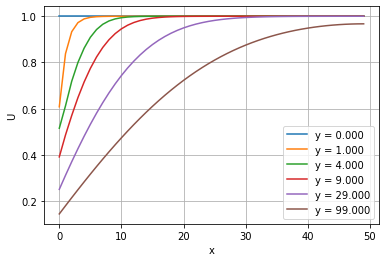

In [15]:
plt.xlabel('x'); plt.ylabel('U')
# times = np.array([0., 0.1, 0.2, 0.5, 1., 2., 5.])  # h
# timeIndeces = (times*3600/tScale*Ny + 0.5).astype(int)
timeIndeces = np.array([1, 2, 5, 10, 30, 100]) - 1
print(timeIndeces)
for timeIndex in timeIndeces:
    plt.plot(range(len(USoln[timeIndex])), USoln[timeIndex], label='y = '+'{:.3f}'.format(timeIndex))
# plt.xlim(0, 0.1)
plt.legend()
plt.grid()
plt.show()